# ML HW1 | Supervised Learning | Decision Trees
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

## Import Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import time

## Set directory

In [24]:
directory = "/Users/michaelpecorino/Documents/GitLab/nba/"

## Load inputs

In [25]:
ncaa_all = pd.read_csv(directory + "nba_all.csv")
train = pd.read_csv(directory + "nba_train.csv")
valid = pd.read_csv(directory + "nba_valid.csv")
test = pd.read_csv(directory + "nba_test.csv")

## Define features and response variable

### Features

In [26]:
features = ["game_win_perc_prop", 
            "game_starters_total_minutes_prop", "game_starters_prop_minutes_prop", "game_player_pts_10plus_prop",
            "game_player_pts_15plus_prop", "game_player_pts_16plus_prop", "game_player_pts_17plus_prop",
            "game_player_pts_18plus_prop", "game_player_pts_19plus_prop", "game_player_pts_20plus_prop",
            "game_player_pts_21plus_prop", "game_player_pts_22plus_prop", "game_player_ast_3plus_prop",
            "game_player_ast_5plus_prop", "game_player_ast_7plus_prop",
            "game_player_orb_1plus_prop", "game_player_orb_2plus_prop", "game_player_orb_3plus_prop",
            "game_player_drb_5plus_prop", "game_player_drb_7plus_prop", "game_player_drb_10plus_prop",
            "game_gs_mean_prop", "game_gs_max_prop", "game_pos_prop", "game_pts_prop", "game_efficiency_prop",
            "game_fg_attempted_prop", "game_ft_attempted_prop", "game_ft_made_prop", "game_stl_prop",
            "game_tov_prop","game_stl_tov_ratio_diff", "game_stl_tov_ratio_prop", "game_blk_prop",
            "game_orb_prop", "game_drb_prop", "game_trb_prop", "game_ast_prop", "game_pf_diff", "game_pf_prop",
            "home_indicator", "game_age_mean_prop"]
ncaa_all_features = ncaa_all[features]
train_features = train[features]
valid_features = valid[features]
train_valid_features = train_features.append(valid_features)
test_features = test[features]

### Response variable

In [27]:
response_variable = "win_indicator"
ncaa_all_response = ncaa_all[response_variable]
train_response = train[response_variable]
valid_response = valid[response_variable]
train_valid_resposnse = train_response.append(valid_response)
test_response = test[response_variable]

## Decision Tree

### Initial model

In [28]:
decision_tree_model = DecisionTreeClassifier(criterion = 'entropy',
                                             splitter = 'best',
                                             max_depth = None,
                                             min_samples_split = 2,
                                             min_samples_leaf = 1,
                                             min_weight_fraction_leaf = 0.0,
                                             max_features = None,
                                             random_state = 28,
                                             max_leaf_nodes = None,
                                             min_impurity_decrease = 0.0,
                                             min_impurity_split = None,
                                             class_weight = None,
                                             ccp_alpha = 0.0001)

decision_tree_model.fit(train_features, train_response) 

print("Decision tree accuracy on training data: ",
      decision_tree_model.score(train_features, train_response))
print("Decision tree accuracy on validation data: ",
      decision_tree_model.score(valid_features, valid_response))

Decision tree accuracy on training data:  0.9966814159292036
Decision tree accuracy on validation data:  0.591994835377663


### Cost complexity pruning path
https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py

#### Get the CCP

In [29]:
path = decision_tree_model.cost_complexity_pruning_path(train_features, train_response)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp_df = pd.DataFrame(columns = ['ccp_alphas', 'impurities'])
for i in range(0,len(ccp_alphas)):
    ccp_df = ccp_df.append({'ccp_alphas': ccp_alphas[i].round(6),
                            'impurities': impurities[i].round(3)},
                          ignore_index = True)

ccp_df_unique = ccp_df.drop_duplicates()
ccp_alphas = np.array(ccp_df_unique["ccp_alphas"])
impurities = np.array(ccp_df_unique["impurities"])

#### Plot the CCP

Text(0.5, 1.0, 'Total impurity vs effective alpha for training data')

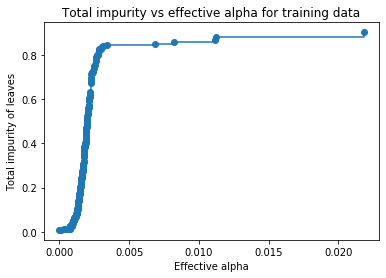

In [30]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker = 'o', drawstyle = "steps-post")
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total impurity vs effective alpha for training data")

### Train a decision tree for each ccp_alpha and evaluate on cross-validation

In [31]:
folds = set(train['fold'])
folds

{1, 2, 3, 4, 5}

In [18]:
decision_tree_ccps = []
cross_validation_results = pd.DataFrame(columns = ['ccp_alpha', 'fold', 'in_fold_score', 'out_fold_score'])

iter = 0
for ccp_alpha in ccp_alphas:
    iter = iter+1
    
    for fold in folds:
        
        #Debugging
        #ccp_alpha = .0004
        #fold = 1
        
        train_features_in_fold = train[train["fold"] != fold][features]
        train_response_in_fold = train[train["fold"] != fold][response_variable]
        
        test_features_out_fold = train[train["fold"] == fold][features]
        test_response_out_fold = train[train["fold"] == fold][response_variable]

        print("iter:", iter, "ccp_alpha:", ccp_alpha, "impurity:", impurities[iter-1], "for fold:", fold)
        
        decision_tree_ccp = DecisionTreeClassifier(criterion = 'entropy',
                                                   splitter = 'best',
                                                   max_depth = None,
                                                   min_samples_split = 2,
                                                   min_samples_leaf = 1,
                                                   min_weight_fraction_leaf = 0.0,
                                                   max_features = None,
                                                   random_state = 28,
                                                   max_leaf_nodes = None,
                                                   min_impurity_decrease = 0.0,
                                                   min_impurity_split = None,
                                                   class_weight = None,
                                                   ccp_alpha = ccp_alpha)
        
        decision_tree_ccp.fit(train_features_in_fold, train_response_in_fold)
        decision_tree_ccps.append(decision_tree_ccp)
        
        #Evaluate
        in_fold_score = decision_tree_ccp.score(train_features_in_fold, train_response_in_fold)
        out_fold_score = decision_tree_ccp.score(test_features_out_fold, test_response_out_fold)
        
        cross_validation_results = cross_validation_results.append({'ccp_alpha': ccp_alpha,
                                                                    'fold': fold,
                                                                    'in_fold_score': in_fold_score,
                                                                    'out_fold_score': out_fold_score},
                                                                 ignore_index = True)

iter: 1 ccp_alpha: 0.0 impurity: 0.008 for fold: 1
iter: 1 ccp_alpha: 0.0 impurity: 0.008 for fold: 2
iter: 1 ccp_alpha: 0.0 impurity: 0.008 for fold: 3
iter: 1 ccp_alpha: 0.0 impurity: 0.008 for fold: 4
iter: 1 ccp_alpha: 0.0 impurity: 0.008 for fold: 5
iter: 2 ccp_alpha: 0.000111 impurity: 0.008 for fold: 1
iter: 2 ccp_alpha: 0.000111 impurity: 0.008 for fold: 2
iter: 2 ccp_alpha: 0.000111 impurity: 0.008 for fold: 3
iter: 2 ccp_alpha: 0.000111 impurity: 0.008 for fold: 4
iter: 2 ccp_alpha: 0.000111 impurity: 0.008 for fold: 5
iter: 3 ccp_alpha: 0.000332 impurity: 0.01 for fold: 1
iter: 3 ccp_alpha: 0.000332 impurity: 0.01 for fold: 2
iter: 3 ccp_alpha: 0.000332 impurity: 0.01 for fold: 3
iter: 3 ccp_alpha: 0.000332 impurity: 0.01 for fold: 4
iter: 3 ccp_alpha: 0.000332 impurity: 0.01 for fold: 5
iter: 4 ccp_alpha: 0.000379 impurity: 0.01 for fold: 1
iter: 4 ccp_alpha: 0.000379 impurity: 0.01 for fold: 2
iter: 4 ccp_alpha: 0.000379 impurity: 0.01 for fold: 3
iter: 4 ccp_alpha: 0.0003

iter: 30 ccp_alpha: 0.000897 impurity: 0.036 for fold: 2
iter: 30 ccp_alpha: 0.000897 impurity: 0.036 for fold: 3
iter: 30 ccp_alpha: 0.000897 impurity: 0.036 for fold: 4
iter: 30 ccp_alpha: 0.000897 impurity: 0.036 for fold: 5
iter: 31 ccp_alpha: 0.000897 impurity: 0.037 for fold: 1
iter: 31 ccp_alpha: 0.000897 impurity: 0.037 for fold: 2
iter: 31 ccp_alpha: 0.000897 impurity: 0.037 for fold: 3
iter: 31 ccp_alpha: 0.000897 impurity: 0.037 for fold: 4
iter: 31 ccp_alpha: 0.000897 impurity: 0.037 for fold: 5
iter: 32 ccp_alpha: 0.000909 impurity: 0.038 for fold: 1
iter: 32 ccp_alpha: 0.000909 impurity: 0.038 for fold: 2
iter: 32 ccp_alpha: 0.000909 impurity: 0.038 for fold: 3
iter: 32 ccp_alpha: 0.000909 impurity: 0.038 for fold: 4
iter: 32 ccp_alpha: 0.000909 impurity: 0.038 for fold: 5
iter: 33 ccp_alpha: 0.000981 impurity: 0.04 for fold: 1
iter: 33 ccp_alpha: 0.000981 impurity: 0.04 for fold: 2
iter: 33 ccp_alpha: 0.000981 impurity: 0.04 for fold: 3
iter: 33 ccp_alpha: 0.000981 impur

iter: 59 ccp_alpha: 0.001161 impurity: 0.068 for fold: 2
iter: 59 ccp_alpha: 0.001161 impurity: 0.068 for fold: 3
iter: 59 ccp_alpha: 0.001161 impurity: 0.068 for fold: 4
iter: 59 ccp_alpha: 0.001161 impurity: 0.068 for fold: 5
iter: 60 ccp_alpha: 0.001168 impurity: 0.07 for fold: 1
iter: 60 ccp_alpha: 0.001168 impurity: 0.07 for fold: 2
iter: 60 ccp_alpha: 0.001168 impurity: 0.07 for fold: 3
iter: 60 ccp_alpha: 0.001168 impurity: 0.07 for fold: 4
iter: 60 ccp_alpha: 0.001168 impurity: 0.07 for fold: 5
iter: 61 ccp_alpha: 0.001171 impurity: 0.071 for fold: 1
iter: 61 ccp_alpha: 0.001171 impurity: 0.071 for fold: 2
iter: 61 ccp_alpha: 0.001171 impurity: 0.071 for fold: 3
iter: 61 ccp_alpha: 0.001171 impurity: 0.071 for fold: 4
iter: 61 ccp_alpha: 0.001171 impurity: 0.071 for fold: 5
iter: 62 ccp_alpha: 0.001203 impurity: 0.072 for fold: 1
iter: 62 ccp_alpha: 0.001203 impurity: 0.072 for fold: 2
iter: 62 ccp_alpha: 0.001203 impurity: 0.072 for fold: 3
iter: 62 ccp_alpha: 0.001203 impurit

iter: 88 ccp_alpha: 0.001319 impurity: 0.109 for fold: 1
iter: 88 ccp_alpha: 0.001319 impurity: 0.109 for fold: 2
iter: 88 ccp_alpha: 0.001319 impurity: 0.109 for fold: 3
iter: 88 ccp_alpha: 0.001319 impurity: 0.109 for fold: 4
iter: 88 ccp_alpha: 0.001319 impurity: 0.109 for fold: 5
iter: 89 ccp_alpha: 0.001328 impurity: 0.111 for fold: 1
iter: 89 ccp_alpha: 0.001328 impurity: 0.111 for fold: 2
iter: 89 ccp_alpha: 0.001328 impurity: 0.111 for fold: 3
iter: 89 ccp_alpha: 0.001328 impurity: 0.111 for fold: 4
iter: 89 ccp_alpha: 0.001328 impurity: 0.111 for fold: 5
iter: 90 ccp_alpha: 0.001332 impurity: 0.113 for fold: 1
iter: 90 ccp_alpha: 0.001332 impurity: 0.113 for fold: 2
iter: 90 ccp_alpha: 0.001332 impurity: 0.113 for fold: 3
iter: 90 ccp_alpha: 0.001332 impurity: 0.113 for fold: 4
iter: 90 ccp_alpha: 0.001332 impurity: 0.113 for fold: 5
iter: 91 ccp_alpha: 0.001337 impurity: 0.114 for fold: 1
iter: 91 ccp_alpha: 0.001337 impurity: 0.114 for fold: 2
iter: 91 ccp_alpha: 0.001337 im

iter: 116 ccp_alpha: 0.001395 impurity: 0.156 for fold: 4
iter: 116 ccp_alpha: 0.001395 impurity: 0.156 for fold: 5
iter: 117 ccp_alpha: 0.001397 impurity: 0.159 for fold: 1
iter: 117 ccp_alpha: 0.001397 impurity: 0.159 for fold: 2
iter: 117 ccp_alpha: 0.001397 impurity: 0.159 for fold: 3
iter: 117 ccp_alpha: 0.001397 impurity: 0.159 for fold: 4
iter: 117 ccp_alpha: 0.001397 impurity: 0.159 for fold: 5
iter: 118 ccp_alpha: 0.001407 impurity: 0.161 for fold: 1
iter: 118 ccp_alpha: 0.001407 impurity: 0.161 for fold: 2
iter: 118 ccp_alpha: 0.001407 impurity: 0.161 for fold: 3
iter: 118 ccp_alpha: 0.001407 impurity: 0.161 for fold: 4
iter: 118 ccp_alpha: 0.001407 impurity: 0.161 for fold: 5
iter: 119 ccp_alpha: 0.001407 impurity: 0.162 for fold: 1
iter: 119 ccp_alpha: 0.001407 impurity: 0.162 for fold: 2
iter: 119 ccp_alpha: 0.001407 impurity: 0.162 for fold: 3
iter: 119 ccp_alpha: 0.001407 impurity: 0.162 for fold: 4
iter: 119 ccp_alpha: 0.001407 impurity: 0.162 for fold: 5
iter: 120 ccp_

iter: 145 ccp_alpha: 0.001527 impurity: 0.211 for fold: 1
iter: 145 ccp_alpha: 0.001527 impurity: 0.211 for fold: 2
iter: 145 ccp_alpha: 0.001527 impurity: 0.211 for fold: 3
iter: 145 ccp_alpha: 0.001527 impurity: 0.211 for fold: 4
iter: 145 ccp_alpha: 0.001527 impurity: 0.211 for fold: 5
iter: 146 ccp_alpha: 0.001528 impurity: 0.214 for fold: 1
iter: 146 ccp_alpha: 0.001528 impurity: 0.214 for fold: 2
iter: 146 ccp_alpha: 0.001528 impurity: 0.214 for fold: 3
iter: 146 ccp_alpha: 0.001528 impurity: 0.214 for fold: 4
iter: 146 ccp_alpha: 0.001528 impurity: 0.214 for fold: 5
iter: 147 ccp_alpha: 0.001529 impurity: 0.215 for fold: 1
iter: 147 ccp_alpha: 0.001529 impurity: 0.215 for fold: 2
iter: 147 ccp_alpha: 0.001529 impurity: 0.215 for fold: 3
iter: 147 ccp_alpha: 0.001529 impurity: 0.215 for fold: 4
iter: 147 ccp_alpha: 0.001529 impurity: 0.215 for fold: 5
iter: 148 ccp_alpha: 0.001529 impurity: 0.217 for fold: 1
iter: 148 ccp_alpha: 0.001529 impurity: 0.217 for fold: 2
iter: 148 ccp_

iter: 173 ccp_alpha: 0.001687 impurity: 0.286 for fold: 3
iter: 173 ccp_alpha: 0.001687 impurity: 0.286 for fold: 4
iter: 173 ccp_alpha: 0.001687 impurity: 0.286 for fold: 5
iter: 174 ccp_alpha: 0.001688 impurity: 0.288 for fold: 1
iter: 174 ccp_alpha: 0.001688 impurity: 0.288 for fold: 2
iter: 174 ccp_alpha: 0.001688 impurity: 0.288 for fold: 3
iter: 174 ccp_alpha: 0.001688 impurity: 0.288 for fold: 4
iter: 174 ccp_alpha: 0.001688 impurity: 0.288 for fold: 5
iter: 175 ccp_alpha: 0.001691 impurity: 0.29 for fold: 1
iter: 175 ccp_alpha: 0.001691 impurity: 0.29 for fold: 2
iter: 175 ccp_alpha: 0.001691 impurity: 0.29 for fold: 3
iter: 175 ccp_alpha: 0.001691 impurity: 0.29 for fold: 4
iter: 175 ccp_alpha: 0.001691 impurity: 0.29 for fold: 5
iter: 176 ccp_alpha: 0.001695 impurity: 0.291 for fold: 1
iter: 176 ccp_alpha: 0.001695 impurity: 0.291 for fold: 2
iter: 176 ccp_alpha: 0.001695 impurity: 0.291 for fold: 3
iter: 176 ccp_alpha: 0.001695 impurity: 0.291 for fold: 4
iter: 176 ccp_alpha

iter: 201 ccp_alpha: 0.001867 impurity: 0.4 for fold: 5
iter: 202 ccp_alpha: 0.001878 impurity: 0.404 for fold: 1
iter: 202 ccp_alpha: 0.001878 impurity: 0.404 for fold: 2
iter: 202 ccp_alpha: 0.001878 impurity: 0.404 for fold: 3
iter: 202 ccp_alpha: 0.001878 impurity: 0.404 for fold: 4
iter: 202 ccp_alpha: 0.001878 impurity: 0.404 for fold: 5
iter: 203 ccp_alpha: 0.001889 impurity: 0.409 for fold: 1
iter: 203 ccp_alpha: 0.001889 impurity: 0.409 for fold: 2
iter: 203 ccp_alpha: 0.001889 impurity: 0.409 for fold: 3
iter: 203 ccp_alpha: 0.001889 impurity: 0.409 for fold: 4
iter: 203 ccp_alpha: 0.001889 impurity: 0.409 for fold: 5
iter: 204 ccp_alpha: 0.001893 impurity: 0.411 for fold: 1
iter: 204 ccp_alpha: 0.001893 impurity: 0.411 for fold: 2
iter: 204 ccp_alpha: 0.001893 impurity: 0.411 for fold: 3
iter: 204 ccp_alpha: 0.001893 impurity: 0.411 for fold: 4
iter: 204 ccp_alpha: 0.001893 impurity: 0.411 for fold: 5
iter: 205 ccp_alpha: 0.001893 impurity: 0.413 for fold: 1
iter: 205 ccp_al

iter: 230 ccp_alpha: 0.002025 impurity: 0.534 for fold: 2
iter: 230 ccp_alpha: 0.002025 impurity: 0.534 for fold: 3
iter: 230 ccp_alpha: 0.002025 impurity: 0.534 for fold: 4
iter: 230 ccp_alpha: 0.002025 impurity: 0.534 for fold: 5
iter: 231 ccp_alpha: 0.002033 impurity: 0.542 for fold: 1
iter: 231 ccp_alpha: 0.002033 impurity: 0.542 for fold: 2
iter: 231 ccp_alpha: 0.002033 impurity: 0.542 for fold: 3
iter: 231 ccp_alpha: 0.002033 impurity: 0.542 for fold: 4
iter: 231 ccp_alpha: 0.002033 impurity: 0.542 for fold: 5
iter: 232 ccp_alpha: 0.002042 impurity: 0.557 for fold: 1
iter: 232 ccp_alpha: 0.002042 impurity: 0.557 for fold: 2
iter: 232 ccp_alpha: 0.002042 impurity: 0.557 for fold: 3
iter: 232 ccp_alpha: 0.002042 impurity: 0.557 for fold: 4
iter: 232 ccp_alpha: 0.002042 impurity: 0.557 for fold: 5
iter: 233 ccp_alpha: 0.002043 impurity: 0.559 for fold: 1
iter: 233 ccp_alpha: 0.002043 impurity: 0.559 for fold: 2
iter: 233 ccp_alpha: 0.002043 impurity: 0.559 for fold: 3
iter: 233 ccp_

iter: 258 ccp_alpha: 0.002468 impurity: 0.742 for fold: 4
iter: 258 ccp_alpha: 0.002468 impurity: 0.742 for fold: 5
iter: 259 ccp_alpha: 0.002482 impurity: 0.75 for fold: 1
iter: 259 ccp_alpha: 0.002482 impurity: 0.75 for fold: 2
iter: 259 ccp_alpha: 0.002482 impurity: 0.75 for fold: 3
iter: 259 ccp_alpha: 0.002482 impurity: 0.75 for fold: 4
iter: 259 ccp_alpha: 0.002482 impurity: 0.75 for fold: 5
iter: 260 ccp_alpha: 0.002557 impurity: 0.755 for fold: 1
iter: 260 ccp_alpha: 0.002557 impurity: 0.755 for fold: 2
iter: 260 ccp_alpha: 0.002557 impurity: 0.755 for fold: 3
iter: 260 ccp_alpha: 0.002557 impurity: 0.755 for fold: 4
iter: 260 ccp_alpha: 0.002557 impurity: 0.755 for fold: 5
iter: 261 ccp_alpha: 0.002638 impurity: 0.773 for fold: 1
iter: 261 ccp_alpha: 0.002638 impurity: 0.773 for fold: 2
iter: 261 ccp_alpha: 0.002638 impurity: 0.773 for fold: 3
iter: 261 ccp_alpha: 0.002638 impurity: 0.773 for fold: 4
iter: 261 ccp_alpha: 0.002638 impurity: 0.773 for fold: 5
iter: 262 ccp_alpha

In [32]:
print("Number of nodes in the last tree is:", decision_tree_ccps[-1].tree_.node_count,
      "with ccp_alpha:", ccp_alphas[-1])

Number of nodes in the last tree is: 3 with ccp_alpha: 0.09631


In [33]:
cross_validation_results.to_csv(directory + "decision_tree_cv.csv")
cross_validation_results

,ccp_alpha,fold,in_fold_score,out_fold_score
0,0.00000,1.0,0.997580,0.617403
1,0.00000,2.0,0.996889,0.596127
2,0.00000,3.0,0.996543,0.609959
3,0.00000,4.0,0.996198,0.618257
4,0.00000,5.0,0.997926,0.621024
...,...,...,...,...
1395,0.09631,1.0,0.504149,0.504144
1396,0.09631,2.0,0.681300,0.676349
1397,0.09631,3.0,0.687867,0.650069
1398,0.09631,4.0,0.506395,0.495159


### Get the cross-validation summary

In [34]:
cross_validation_results = pd.read_csv(directory + "decision_tree_cv.csv")
cross_validation_results

,Unnamed: 0,ccp_alpha,fold,in_fold_score,out_fold_score
0,0,0.00000,1.0,0.997580,0.617403
1,1,0.00000,2.0,0.996889,0.596127
2,2,0.00000,3.0,0.996543,0.609959
3,3,0.00000,4.0,0.996198,0.618257
4,4,0.00000,5.0,0.997926,0.621024
...,...,...,...,...,...
1395,1395,0.09631,1.0,0.504149,0.504144
1396,1396,0.09631,2.0,0.681300,0.676349
1397,1397,0.09631,3.0,0.687867,0.650069
1398,1398,0.09631,4.0,0.506395,0.495159


### Learning curve

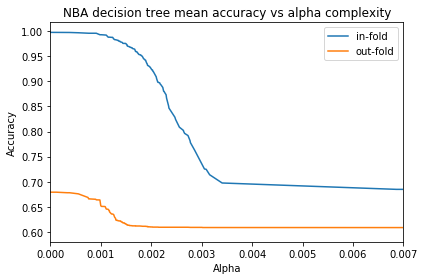

In [36]:
in_fold_c_summary = cross_validation_results.groupby('ccp_alpha')['in_fold_score'].agg(['mean']).sort_values(by = ['mean'], ascending = False)
out_fold_c_summary = cross_validation_results.groupby('ccp_alpha')['out_fold_score'].agg(['mean']).sort_values(by = ['mean'], ascending = False)
fig, ax = plt.subplots()

ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.set_xlim(.0, .007)
ax.set_title("NBA decision tree mean accuracy vs alpha complexity")
ax.plot(cross_validation_results["ccp_alpha"].unique(),
        in_fold_c_summary['mean'],
        label = "in-fold")
ax.plot(cross_validation_results["ccp_alpha"].unique(),
        out_fold_c_summary['mean'],
        label = "out-fold")
ax.legend()

fig.tight_layout()

### Train a final model with the optimal complexity

In [37]:
ccp_alpha_opt = 0.011242
decision_tree_model_final = DecisionTreeClassifier(criterion = 'entropy',
                                                     splitter = 'best',
                                                     max_depth = None,
                                                     min_samples_split = 2,
                                                     min_samples_leaf = 1,
                                                     min_weight_fraction_leaf = 0.0,
                                                     max_features = None,
                                                     random_state = 28,
                                                     max_leaf_nodes = None,
                                                     min_impurity_decrease = 0.0,
                                                     min_impurity_split = None,
                                                     class_weight = None,
                                                     ccp_alpha = ccp_alpha_opt)

decision_tree_model_final.fit(train_features, train_response) 

print("Decision tree accuracy on training data: ",
      decision_tree_model_final.score(train_features, train_response))
print("Decision tree accuracy on validation data: ",
      decision_tree_model_final.score(valid_features, valid_response))
print("Decision tree accuracy on test data: ",
      decision_tree_model_final.score(test_features, test_response))

Decision tree accuracy on training data:  0.6803097345132744
Decision tree accuracy on validation data:  0.6636539703034215
Decision tree accuracy on test data:  0.6598915989159891


In [38]:
train_scores = [decision_tree_ccp.score(train_features, train_response) for decision_tree_ccp in decision_tree_ccps]
valid_scores = [decision_tree_ccp.score(valid_features, valid_response) for decision_tree_ccp in decision_tree_ccps]
test_scores = [decision_tree_ccp.score(test_features, test_response) for decision_tree_ccp in decision_tree_ccps]

In [39]:
print(max(train_scores))
print(max(valid_scores))
print(max(test_scores))

0.922566371681416
0.6830213040671401
0.6770551038843722


### Function of training size

In [40]:
decision_tree_train_sizes = []
decision_tree_train_size_train_scores = []
decision_tree_train_size_test_scores = []
decision_tree_train_size_train_time = []
decision_tree_train_size_score_time = []

iter = 0
train_sizes = np.linspace(.05,.95, 19)
for train_size in train_sizes:
    (train_features_train_size, test_features_train_size,
    train_response_train_size, test_response_train_size) = train_test_split(ncaa_all_features,
                                                                            ncaa_all_response,
                                                                            train_size = train_size,
                                                                            random_state = 28)
    (train_features_train_size, test_features_train_size,
    train_response_train_size, test_response_train_size) = train_test_split(ncaa_all_features,
                                                                            ncaa_all_response,
                                                                            train_size = train_size,
                                                                            random_state = 28)
    
    iter = iter + 1
    print("iter:", iter,
          " | train size:", train_size)
    decision_tree_train_size = DecisionTreeClassifier(criterion = 'entropy',
                                                      splitter = 'best',
                                                      max_depth = None,
                                                      min_samples_split = 2,
                                                      min_samples_leaf = 1,
                                                      min_weight_fraction_leaf = 0.0,
                                                      max_features = None,
                                                      random_state = 28,
                                                      max_leaf_nodes = None,
                                                      min_impurity_decrease = 0.0,
                                                      min_impurity_split = None,
                                                      class_weight = None,
                                                      ccp_alpha = ccp_alpha_opt)
    start = time.time()
    decision_tree_train_size.fit(train_features_train_size, train_response_train_size)
    end = time.time()
    decision_tree_train_size_train_time.append(end - start)

    decision_tree_train_sizes.append(decision_tree_train_size)
    
    start = time.time()
    decision_tree_train_size_train_scores.append(decision_tree_train_size.score(train_features_train_size, train_response_train_size)) 
    end = time.time()
    decision_tree_train_size_score_time.append(end - start)

    decision_tree_train_size_test_scores.append(decision_tree_train_size.score(test_features_train_size, test_response_train_size))
    

iter: 1  | train size: 0.05
iter: 2  | train size: 0.1
iter: 3  | train size: 0.15
iter: 4  | train size: 0.2
iter: 5  | train size: 0.25
iter: 6  | train size: 0.3
iter: 7  | train size: 0.35
iter: 8  | train size: 0.39999999999999997
iter: 9  | train size: 0.44999999999999996
iter: 10  | train size: 0.49999999999999994
iter: 11  | train size: 0.5499999999999999
iter: 12  | train size: 0.6
iter: 13  | train size: 0.65
iter: 14  | train size: 0.7
iter: 15  | train size: 0.75
iter: 16  | train size: 0.7999999999999999
iter: 17  | train size: 0.85
iter: 18  | train size: 0.9
iter: 19  | train size: 0.95


### Plotting the learning curve by training size, for a fixed complexity

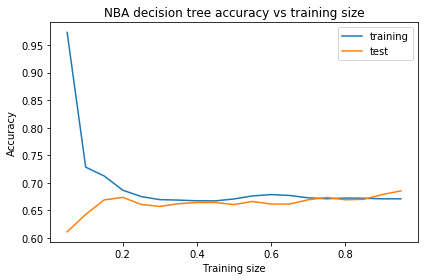

In [44]:
fig, ax = plt.subplots()

ax.set_xlabel("Training size")
ax.set_ylabel("Accuracy")
ax.set_title("NBA decision tree accuracy vs training size")
ax.plot(train_sizes, decision_tree_train_size_train_scores, label = "training",
        #drawstyle = "steps-post"
       )
ax.plot(train_sizes, decision_tree_train_size_test_scores, label = "test",
        #drawstyle = "steps-post"
       )
ax.legend()

fig.tight_layout()

###  Plotting the model fitting time as a function of the training size

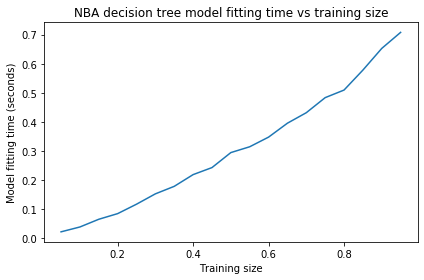

In [45]:
fig, ax = plt.subplots()

ax.set_xlabel("Training size")
ax.set_ylabel("Model fitting time (seconds)")
ax.set_title("NBA decision tree model fitting time vs training size")
ax.plot(train_sizes, decision_tree_train_size_train_time, label = "training",
        #drawstyle = "steps-post"
       )

fig.tight_layout()

### Plotting the model scoring time as a function of the training size

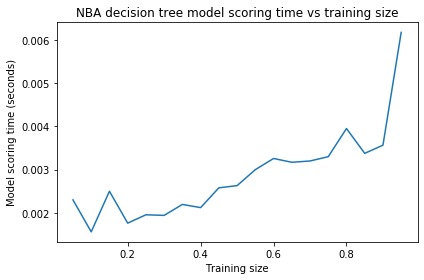

In [46]:
fig, ax = plt.subplots()

ax.set_xlabel("Training size")
ax.set_ylabel("Model scoring time (seconds)")
ax.set_title("NBA decision tree model scoring time vs training size")
ax.plot(train_sizes, decision_tree_train_size_score_time, label = "training",
        #drawstyle = "steps-post"
       )

fig.tight_layout()